Week 06 Project 05

In [10]:
#packages

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import moment
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from scipy.stats import norm, t, lognorm
from scipy.optimize import minimize
from scipy.integrate import quad
import pandas as pd
import time
from tqdm import tqdm
import math
from scipy.optimize import minimize_scalar


- Problem 1

Assume you a call and a put option with the following
- Current Stock Price $165
- Current Date 03/03/2023
- Options Expiration Date 03/17/2023
- Risk Free Rate of 5.25%
- Continuously Compounding Coupon of 0.53%
Calculate the time to maturity using calendar days (not trading days).
For a range of implied volatilities between 10% and 80%, plot the value of the call and the put. Discuss these graphs. How does the supply and demand affect the implied volatility?

In [3]:
def integral_bsm_with_coupons(call, underlying, strike, days, rf, ivol, tradingDayYear, couponRate, function_type = "Black Scholes", q=None):
    
    if function_type == "Black Scholes":
        b = rf
    if function_type == "Merton":
        b = rf - q
    
    # time to maturity
    ttm = days / tradingDayYear

    # daily volatility with continuously compounded implied volatility
    dailyVol = ivol / np.sqrt(tradingDayYear)

    # std dev and mean for log normal distribution
    sigma = np.sqrt(days) * dailyVol
    mu = np.log(underlying) + ttm * b - 0.5 * sigma**2

    # log normal distribution
    d = lognorm(scale=np.exp(mu), s=sigma)

    # calculate the present value of coupons
    couponPV = 0.0
    for day in range(int(ttm * tradingDayYear)):
        # present value of the coupon payment for each day, 
         couponPV += couponRate * np.exp(-rf * (day / tradingDayYear))

    if call:
        # option value for call
        def f(x):
            return (max(0, x - strike) + couponPV) * d.pdf(x)
        val, _ = quad(f, 0, underlying * 2)
    else:
        # option value for put
        def g(x):
            return (max(0, strike - x) + couponPV) * d.pdf(x)
        val, _ = quad(g, 0, underlying * 2)

    return val * np.exp(-rf * ttm)


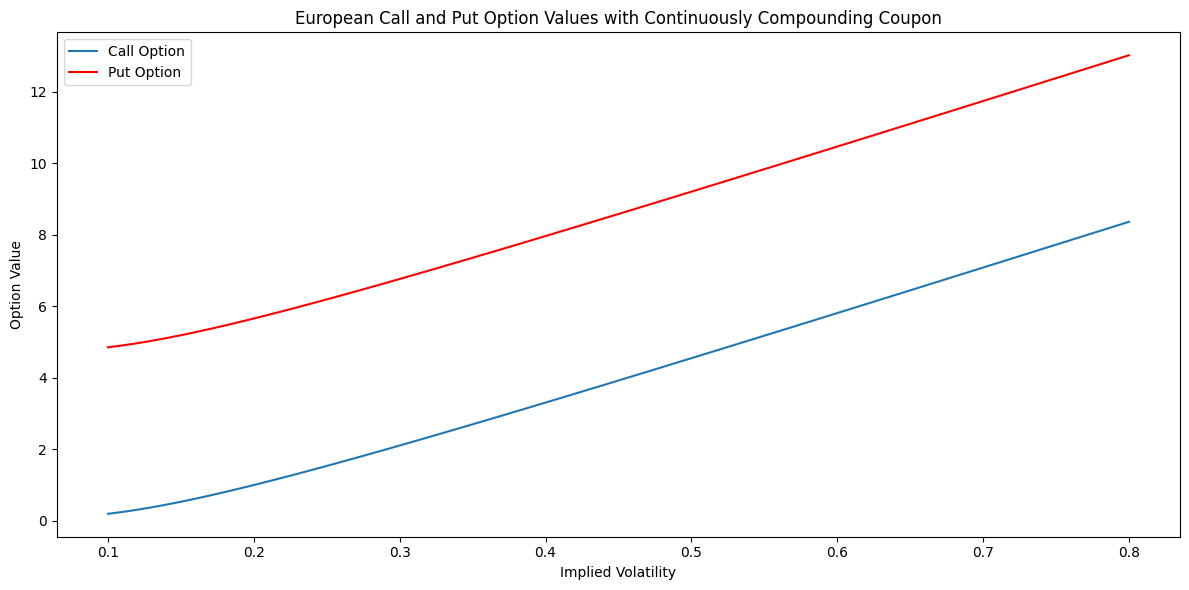

In [4]:
# provided values
underlying_price = 165
strike = 170
start_date = datetime(2023, 3, 3)
options_expiration_date = datetime(2023, 3, 17)
days_to_maturity = (options_expiration_date - start_date).days
trading_days_in_year = 365
risk_free_rate = 0.0525
continuously_compounding_coupon_rate = 0.0053

implied_volatilities = np.linspace(0.1, 0.8, 100)

call_option_values = []
put_option_values = []

# calculate option values for each implied volatility
for ivol in implied_volatilities:
    # calculate the European call option value
    call_option_value = integral_bsm_with_coupons(True, underlying_price, strike, days_to_maturity, risk_free_rate, ivol, trading_days_in_year, continuously_compounding_coupon_rate)
    call_option_values.append(call_option_value)

    # calculate the European put option value
    put_option_value = integral_bsm_with_coupons(False, underlying_price, strike, days_to_maturity, risk_free_rate, ivol, trading_days_in_year, continuously_compounding_coupon_rate)
    put_option_values.append(put_option_value)

plt.figure(figsize=(12, 6))

plt.plot(implied_volatilities, call_option_values, label='Call Option')
plt.plot(implied_volatilities, put_option_values, label='Put Option', color='red')

plt.title('European Call and Put Option Values with Continuously Compounding Coupon')
plt.xlabel('Implied Volatility')
plt.ylabel('Option Value')
plt.legend()

plt.tight_layout()
plt.show()

- Problem 2

Use the options found in AAPL_Options.csv
- Current AAPL price is 170.15
- Current Date: 10/30/2023
- Risk Free Rate: 5.25%
- Dividend Rate: 0.57%.

Calculate the implied volatility for each option.
Plot the implied volatility vs the strike price for Puts and Calls. Discuss the shape of these graphs. What market dynamics could make these graphs?
There are bonus points available on this question based on your discussion. Take some time to research if needed.

In [5]:
def options_price(S, X, T, sigma, r, b, option_type='call'):
    """
    S: Underlying Price
    X: Strike
    T: Time to Maturity(in years)
    sigma: implied volatility
    r: risk free rate
    b: cost of carry -> r if black scholes, r-q if merton
    """
    d1 = (math.log(S/X) + (b + 0.5*sigma**2)*T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    if option_type == 'call':
        return S * math.exp((b - r) * T) * norm.cdf(d1) - X * math.exp(-r * T) * norm.cdf(d2)
    else:
        return X * math.exp(-r * T) * norm.cdf(-d2) - S * math.exp((b - r) * T) * norm.cdf(-d1)

def option_price_error(sigma, S, X, T, r, b, option_type, market_price):
    option_price = options_price(S, X, T, sigma, r, b, option_type)
    return abs(option_price - market_price)

  Stock  Expiration  Type  Strike  Last Price
0  AAPL  12/15/2023  Call     140       30.95
1  AAPL  12/15/2023  Call     145       26.74
2  AAPL  12/15/2023  Call     150       22.80
3  AAPL  12/15/2023  Call     155       18.40
4  AAPL  12/15/2023  Call     160       14.15


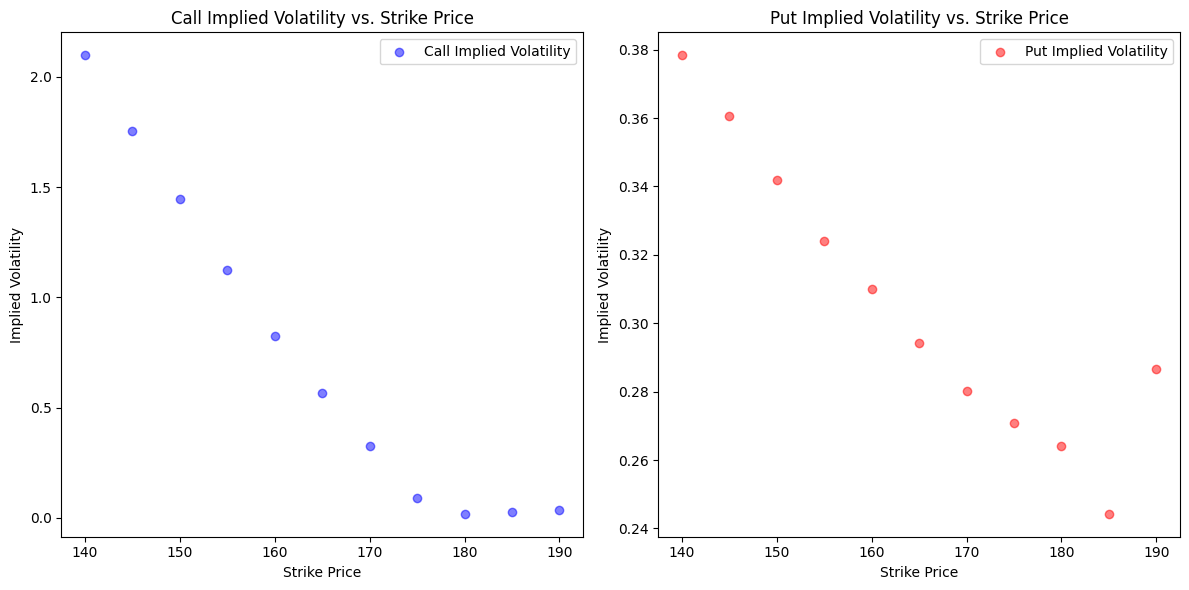

In [11]:

# apple_options = pd.read_csv("Week06/Project/AAPL_Options.csv")

apple_options = pd.read_csv("AAPL_Options.csv")
print(apple_options.head())
# Stock Expiration Type Strike Last Price

# Current AAPL price
aapl_price = 170.15
curr_date = datetime(2023, 10, 30)
risk_free = 0.0525
dividend_rate = 0.0057

# Create empty lists to store implied volatilities and strike prices for calls and puts
call_strike_prices = []
call_implied_volatilities = []
put_strike_prices = []
put_implied_volatilities = []

# Iterate through each option in apple_options
for i in range(len(apple_options)):
    S = aapl_price
    X = apple_options['Strike'][i]
    T = (datetime.strptime(apple_options['Expiration'][i], "%m/%d/%Y") - curr_date).days / 365.0
    r = risk_free
    b = risk_free - dividend_rate
    option_type = apple_options['Type'][i]
    market_price = apple_options['Last Price'][i]

    # Use optimizer to find implied volatility
    result = minimize_scalar(
        lambda sigma: option_price_error(sigma, S, X, T, r, b, option_type, market_price),
        bounds=(0.001, 10.0)  # Adjust the bounds as needed
    )
    implied_volatility = result.x

    # Separate implied volatilities and strike prices for calls and puts
    if option_type == 'Call':
        call_strike_prices.append(X)
        call_implied_volatilities.append(implied_volatility)
    else:
        put_strike_prices.append(X)
        put_implied_volatilities.append(implied_volatility)

# Plot implied volatility vs. strike price for calls and puts separately
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(call_strike_prices, call_implied_volatilities, c='blue', alpha=0.5, label='Call Implied Volatility')
plt.title('Call Implied Volatility vs. Strike Price')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(put_strike_prices, put_implied_volatilities, c='red', alpha=0.5, label='Put Implied Volatility')
plt.title('Put Implied Volatility vs. Strike Price')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()

plt.tight_layout()
plt.show()

- Problem 3

Use the portfolios found in problem3.csv

- Current AAPL price is 170.15
- Current Date: 10/30/2023
- Risk Free Rate: 5.25%
- Dividend Rate: 0.57%.

For each of the portfolios, graph the portfolio value over a range of underlying values. Plot the portfolio values and discuss the shapes. Bonus points available for tying these graphs to other topics discussed in the lecture.
Using DailyPrices.csv. Calculate the log returns of AAPL. Demean the series so there is 0 mean. Fit an AR(1) model to AAPL returns. Simulate AAPL returns 10 days ahead and apply those returns to the current AAPL price (above). Calculate Mean, VaR and ES. Discuss.

Hints:
- you will need to calculate the implied volatility - might not be the same as #2
- you need to take into account the change in dates for option valuations. You are simulating
forward in time and options valuations are a function of time
- Calculate the PL from the current portfolio value using Current Date

In [16]:
def return_calculate(prices_df, method="DISCRETE", date_column="Date"):
    vars = prices_df.columns
    n_vars = len(vars)
    vars = [var for var in vars if var != date_column]
    
    if n_vars == len(vars):
        raise ValueError(f"date_column: {date_column} not in DataFrame: {vars}")
    
    n_vars = n_vars - 1
    
    p = prices_df[vars].values
    n = p.shape[0]
    m = p.shape[1]
    p2 = np.empty((n-1, m))
    
    for i in range(n-1):
        for j in range(m):
            p2[i, j] = p[i+1, j] / p[i, j]
    
    if method.upper() == "DISCRETE":
        p2 = p2 - 1.0
    elif method.upper() == "LOG":
        p2 = np.log(p2)
    else:
        raise ValueError(f"method: {method} must be in (\"LOG\",\"DISCRETE\")")
    
    dates = prices_df[date_column].iloc[1:]
    
    # Create a new DataFrame with all columns
    data = {date_column: dates}
    for i in range(n_vars):
        data[vars[i]] = p2[:, i]
    
    out = pd.DataFrame(data)
    
    return out

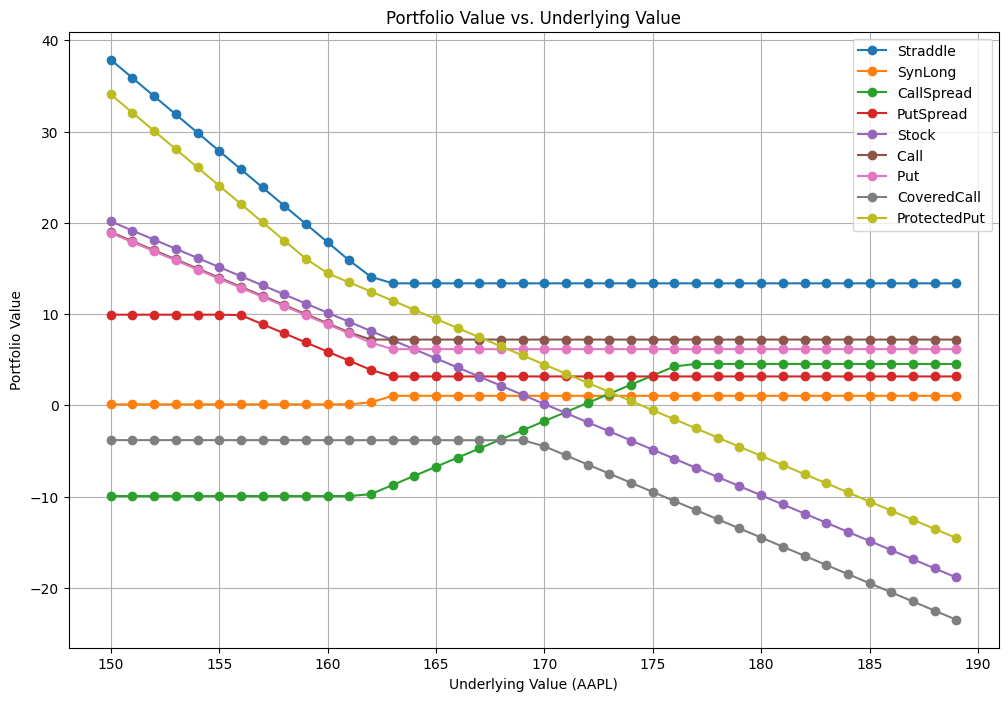

Mean Price: 176.62566231016882
VaR for Normal: 169.97788354455034
Expected Shortfall (ES) for Normal (Manual): 168.28907954278213
Next 10 Prices: [169.2933512308045, 173.04192937741098, 178.05395209675774, 177.50239227790567, 182.9549082002143, 181.21528660455945, 179.4342717026842, 171.74703906601985, 175.7698124353034, 177.2436801100279]


In [21]:
# import pandas as pd
# from datetime import datetime
# import sys
# sys.path.append('C:/Users/lesli/Documents/Duke/Masters/FinTech545')
# import fin_package as fin
# from scipy.optimize import minimize_scalar
# import numpy as np
# import matplotlib.pyplot as plt
from scipy.stats import norm
from arch import arch_model

problem3 = pd.read_csv("problem3.csv")
# Portfolio Type (Option/Stock) Underlying Holding (1/-1) OptionType ExpirationDate Strike CurrentPrice

portfolios = problem3['Portfolio'].unique()

aapl_price = 170.15
curr_date = datetime.strptime("10/30/2023", "%m/%d/%Y")
risk_free = 0.0525  # 5.25%
dividend_rate = 0.0057  # 0.57%

# Function to calculate the portfolio value for a given underlying value
def calculate_portfolio_value(underlying_value, portfolio):
    portfolio_value = 0.0

    for _, asset in portfolio.iterrows():
        if asset['Type'] == 'Option':
            S = underlying_value
            X = asset['Strike']
            T = (datetime.strptime(asset['ExpirationDate'], "%m/%d/%Y") - curr_date).days / 365.0
            option_type = asset['OptionType']
            market_price = asset['CurrentPrice']
            b = risk_free - dividend_rate if option_type == 'Call' else risk_free

            result = minimize_scalar(
                lambda sigma: option_price_error(sigma, S, X, T, risk_free, b, option_type, market_price),
                bounds=(0.001, 5.0)  # Adjust the bounds as needed
            )
            implied_volatility = result.x

            # Calculate the option value using implied volatility
            option_value = options_price(S, X, T, implied_volatility, risk_free, b, option_type)

            # Add or subtract option value to the portfolio based on Holding (1 or -1)
            portfolio_value += asset['Holding'] * option_value
        elif asset['Type'] == 'Stock':
            # If it's a stock, just add its current price to the portfolio value
            portfolio_value += asset['Holding'] * (asset['CurrentPrice'] - underlying_value)

    return portfolio_value

underlying_values = np.arange(150.0, 190.0, 1.0)

plt.figure(figsize=(12, 8))

for portfolio_name in portfolios:
    portfolio_data = problem3[problem3['Portfolio'] == portfolio_name]

    portfolio_values = [calculate_portfolio_value(underlying_value, portfolio_data) for underlying_value in underlying_values]
    
    plt.plot(underlying_values, portfolio_values, label=portfolio_name, marker='o')

plt.xlabel('Underlying Value (AAPL)')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value vs. Underlying Value')
plt.grid(True)
plt.legend()  # Add legend to differentiate portfolios by color
plt.show()


daily_prices = pd.read_csv("DailyPrices.csv")
aapl = daily_prices[['Date', 'AAPL']]

# Calculate the log returns of AAPL
log_returns = return_calculate(aapl, method="LOG")

# Demean the series so there is 0 mean
aapl_mean = log_returns["AAPL"].mean()
centered_returns = log_returns["AAPL"] - aapl_mean

# Function to fit an AR(1) model to data
def fit_ar1(data):
    n = len(data)
    x_t = data[:-1]
    x_t1 = data[1:]
    alpha = np.cov(x_t, x_t1)[0, 1] / np.var(x_t)
    epsilon = x_t1 - alpha * x_t
    sigma = np.std(epsilon)
    return alpha, sigma

# Created new AR(1) model due to issues with prior models
alpha, sigma = fit_ar1(centered_returns)

# predictions for the next 10 returns
num_steps = 10
predictions = np.empty(num_steps)
current_data = centered_returns.values

for t in range(num_steps):
    epsilon_t = np.random.normal(0, sigma)
    next_return = alpha * current_data[-1] + epsilon_t
    predictions[t] = next_return
    current_data = np.append(current_data, next_return)

initial_price = 170.15

# calculate prices from returns
def calculate_prices(initial_price, returns):
    prices = [initial_price]
    for r in returns:
        price_t = prices[-1] * (1 + r)
        prices.append(price_t)
    return prices[1:]

# calculate the next 10 prices
next_10_prices = calculate_prices(initial_price, predictions)

mean_price = np.mean(next_10_prices)
std_dev_price = np.std(next_10_prices)

alpha = 0.05

z_alpha = norm.ppf(alpha)
var_price = mean_price + std_dev_price * z_alpha

# Calculate ES using the manual formula
z_alpha = norm.ppf(alpha)  # Calculate the z-score for the given alpha level
es_price_manual = mean_price - (std_dev_price * (norm.pdf(z_alpha) / alpha))

# Print the results
print("Mean Price:", mean_price)
print("VaR for Normal:", var_price)
print("Expected Shortfall (ES) for Normal (Manual):", es_price_manual)
print("Next 10 Prices:", next_10_prices)